## Section 1: Environment Setup & Imports

In [10]:
# =============================================================================
# SECTION 1: ENVIRONMENT SETUP & IMPORTS
# =============================================================================

# --- Standard Library ---
import os
import sys
import glob
import json
import pickle
import hashlib
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any

# --- Data Processing ---
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

# --- Deep Learning ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Progress Bar ---
from tqdm.notebook import tqdm

# --- Suppress Warnings ---
warnings.filterwarnings('ignore')

# =============================================================================
# REPRODUCIBILITY & DEVICE SETUP
# =============================================================================

def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device(use_cuda: bool = True) -> torch.device:
    """Get the best available device."""
    if use_cuda and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

def maybe_compile_model(model: nn.Module, enable: bool = True) -> nn.Module:
    """Apply torch.compile() for PyTorch 2.0+ optimization (optional)."""
    if enable and hasattr(torch, 'compile'):
        try:
            model = torch.compile(model, mode='reduce-overhead')
            print("Model compiled with torch.compile()")
        except Exception as e:
            print(f"torch.compile() failed, using eager mode: {e}")
    return model

# --- Initialize ---
SEED = 42
set_seed(SEED)
DEVICE = get_device(use_cuda=True)

print(f"\nPyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")

Using GPU: NVIDIA GeForce RTX 3060
CUDA Version: 12.8

PyTorch Version: 2.9.1+cu128
NumPy Version: 2.3.3
Pandas Version: 2.3.3


## Section 2: Base Configuration & Utility Functions

In [11]:
# =============================================================================
# SECTION 2: BASE CONFIGURATION & UTILITY FUNCTIONS
# =============================================================================

# --- PATH CONFIGURATION ---
# All paths relative to notebook location
BASE_DIR = Path('./basin_dataset_public')
FORCING_DIR = BASE_DIR / 'basin_mean_forcing' / 'nldas'
FLOW_DIR = BASE_DIR / 'usgs_streamflow'
BAD_BASINS_FILE = BASE_DIR / 'basin_size_errors_10_percent.txt'
CACHE_DIR = Path('./cache')
RESULTS_DIR = Path('./results')

# Create directories if they don't exist
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- PHYSICAL CONSTANTS ---
CFS_TO_CMS = 0.0283168  # Cubic feet/second to cubic meters/second

# --- DATA SPLIT DATES (Hydrological Years) ---
TRAIN_START = '1980-10-01'
TRAIN_END = '1995-09-30'
VAL_START = '1995-10-01'
VAL_END = '2000-09-30'
TEST_START = '2000-10-01'
TEST_END = '2010-09-30'

# --- FEATURE DEFINITIONS ---
# Pure forcing features (known from weather forecasts)
FORCING_FEATURES = ['PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp']

# All dynamic input features (forcing + engineered + autoregressive)
DYNAMIC_FEATURES = [
    'PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp',  # Forcing
    'PRCP_roll3', 'PRCP_roll7',             # Rolling precipitation
    'Q_lag1', 'Q_lag2', 'Q_lag3'            # Lagged flow
]

# Static basin attributes
STATIC_FEATURES = [
    'area_gages2', 'elev_mean', 'slope_mean',
    'sand_frac', 'clay_frac', 'frac_forest',
    'lai_max', 'p_mean', 'aridity'
]

TARGET = 'Q_cms'

# =============================================================================
# CACHING UTILITIES (with auto-invalidation)
# =============================================================================

def compute_config_hash(config_dict: Dict) -> str:
    """Compute hash of configuration for cache invalidation."""
    config_str = json.dumps(config_dict, sort_keys=True, default=str)
    return hashlib.md5(config_str.encode()).hexdigest()[:8]

def get_or_create_cache(
    cache_name: str,
    create_fn: callable,
    config_dict: Dict,
    *args, **kwargs
) -> Any:
    """
    Generic caching utility with auto-invalidation based on config hash.
    
    Args:
        cache_name: Base name for cache file (without extension)
        create_fn: Function to call if cache miss
        config_dict: Configuration dict for invalidation check
        *args, **kwargs: Arguments to pass to create_fn
    
    Returns:
        Cached or freshly computed data
    """
    config_hash = compute_config_hash(config_dict)
    cache_path = CACHE_DIR / f"{cache_name}_{config_hash}.pkl"
    
    if cache_path.exists():
        print(f"    Loading cached data from {cache_path.name}")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    
    print(f"    Computing {cache_name} (will be cached)...")
    data = create_fn(*args, **kwargs)
    
    # Clean old caches with same base name
    for old_cache in CACHE_DIR.glob(f"{cache_name}_*.pkl"):
        if old_cache != cache_path:
            old_cache.unlink()
            print(f"    Removed outdated cache: {old_cache.name}")
    
    with open(cache_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"    Cached to {cache_path.name}")
    
    return data

# =============================================================================
# METRIC UTILITIES
# =============================================================================

def calc_nse(obs: np.ndarray, sim: np.ndarray) -> float:
    """
    Calculate Nash-Sutcliffe Efficiency.
    
    NSE = 1 - (sum((obs - sim)^2) / sum((obs - mean(obs))^2))
    
    Returns:
        NSE value in range (-inf, 1], where 1 is perfect prediction
    """
    obs = np.asarray(obs).flatten()
    sim = np.asarray(sim).flatten()
    
    # Remove NaN pairs
    mask = ~(np.isnan(obs) | np.isnan(sim))
    obs, sim = obs[mask], sim[mask]
    
    if len(obs) == 0:
        return np.nan
    
    denominator = np.sum((obs - np.mean(obs)) ** 2) + 1e-10
    numerator = np.sum((sim - obs) ** 2)
    return float(1 - (numerator / denominator))

def calc_metrics(obs: np.ndarray, sim: np.ndarray) -> Dict[str, float]:
    """Calculate comprehensive regression metrics."""
    obs = np.asarray(obs).flatten()
    sim = np.asarray(sim).flatten()
    
    # Remove NaN pairs
    mask = ~(np.isnan(obs) | np.isnan(sim))
    obs, sim = obs[mask], sim[mask]
    
    if len(obs) == 0:
        return {'NSE': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'Bias': np.nan}
    
    nse = calc_nse(obs, sim)
    mse = np.mean((sim - obs) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(sim - obs))
    
    # R² (coefficient of determination)
    ss_res = np.sum((obs - sim) ** 2)
    ss_tot = np.sum((obs - np.mean(obs)) ** 2) + 1e-10
    r2 = float(1 - ss_res / ss_tot)
    
    # Bias (mean error)
    bias = float(np.mean(sim - obs))
    
    return {
        'NSE': float(round(nse, 4)),
        'RMSE': float(round(rmse, 4)),
        'MAE': float(round(mae, 4)),
        'R2': float(round(r2, 4)),
        'Bias': float(round(bias, 4))
    }

def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    return obj

# =============================================================================
# DATALOADER FACTORY (Optimized)
# =============================================================================

def create_dataloader(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int,
    shuffle: bool = True,
    num_workers: int = 0,
    pin_memory: bool = True
) -> DataLoader:
    """
    Create optimized DataLoader from numpy arrays.
    
    Args:
        X: Input features (N, Seq, Features) or tuple for Seq2Seq
        y: Targets (N,) or (N, Steps)
        batch_size: Batch size
        shuffle: Whether to shuffle data
        num_workers: Number of parallel workers (0 for Windows compatibility)
        pin_memory: Pin memory for faster GPU transfer
    
    Returns:
        PyTorch DataLoader
    """
    if isinstance(X, tuple):
        # Seq2Seq case: (X_past, X_future, Static)
        tensors = [torch.FloatTensor(arr) for arr in X]
        tensors.append(torch.FloatTensor(y))
        dataset = TensorDataset(*tensors)
    else:
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
    
    # Windows compatibility: num_workers=0 avoids multiprocessing issues
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory if torch.cuda.is_available() else False,
        drop_last=False
    )
    return loader

# =============================================================================
# COMPREHENSIVE RESULTS EXPORT
# =============================================================================

def save_comprehensive_results(
    task_name: str,
    model: nn.Module,
    optimizer: optim.Optimizer,
    config: Dict,
    metrics: Dict,
    history: Dict,
    predictions: Dict,
    epoch: int,
    scheduler: Optional[Any] = None
) -> Path:
    """
    Save comprehensive experiment results with timestamp.
    
    Creates a timestamped folder with:
    - best_model.pth (model + optimizer + scheduler state)
    - config.json (full hyperparameters)
    - metrics.json (train/val/test metrics)
    - training_history.json (per-epoch logs)
    - predictions.npz (predictions + ground truth)
    - environment.json (system info)
    
    Returns:
        Path to results folder
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_dir = RESULTS_DIR / task_name / f'run_{timestamp}'
    run_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Save Model Checkpoint (complete state)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config
    }
    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = scheduler.state_dict()
    torch.save(checkpoint, run_dir / 'best_model.pth')
    
    # 2. Save Configuration
    with open(run_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2, default=str)
    
    # 3. Save Metrics
    with open(run_dir / 'metrics.json', 'w') as f:
        json.dump(convert_to_serializable(metrics), f, indent=2)
    
    # 4. Save Training History
    with open(run_dir / 'training_history.json', 'w') as f:
        json.dump(convert_to_serializable(history), f, indent=2)
    
    # 5. Save Predictions
    np.savez(
        run_dir / 'predictions.npz',
        **predictions
    )
    
    # 6. Save Environment Info
    env_info = {
        'timestamp': timestamp,
        'pytorch_version': torch.__version__,
        'cuda_available': torch.cuda.is_available(),
        'cuda_version': torch.version.cuda if torch.cuda.is_available() else None,
        'device': str(DEVICE),
        'random_seed': SEED,
        'numpy_version': np.__version__,
        'pandas_version': pd.__version__
    }
    with open(run_dir / 'environment.json', 'w') as f:
        json.dump(env_info, f, indent=2)
    
    # 7. Append to experiment summary CSV
    summary_file = RESULTS_DIR / task_name / 'experiments_summary.csv'
    summary_row = {
        'timestamp': timestamp,
        'run_dir': str(run_dir),
        **{f'config_{k}': v for k, v in config.items() if not isinstance(v, (list, dict))},
        **{f'test_{k}': v for k, v in metrics.get('test', {}).items()}
    }
    
    if summary_file.exists():
        df_summary = pd.read_csv(summary_file)
        df_summary = pd.concat([df_summary, pd.DataFrame([summary_row])], ignore_index=True)
    else:
        df_summary = pd.DataFrame([summary_row])
    df_summary.to_csv(summary_file, index=False)
    
    print(f"\n  Results saved to: {run_dir}")
    return run_dir

print("Section 2: Base Configuration & Utilities loaded")

Section 2: Base Configuration & Utilities loaded


## Section 3: Data Loading & Feature Engineering Classes

In [12]:
# =============================================================================
# SECTION 3: DATA LOADING & FEATURE ENGINEERING CLASSES
# =============================================================================

class CamelsLoader:
    """
    Loads CAMELS dataset: dynamic forcing data and static basin attributes.
    
    Methods:
        load_bad_basins(): Get list of basins to exclude
        get_basin_list(): Scan directories for valid basins
        load_dynamic_data(): Load streamflow + forcing for a basin
        load_static_attributes(): Load static catchment attributes
    """
    
    def __init__(self):
        self.base_dir = BASE_DIR
        self.forcing_dir = FORCING_DIR
        self.flow_dir = FLOW_DIR
        self.bad_basins_file = BAD_BASINS_FILE
    
    def load_bad_basins(self) -> List[str]:
        """Returns a list of basin IDs to exclude (size errors > 10%)."""
        if not self.bad_basins_file.exists():
            return []
        
        bad_ids = []
        try:
            with open(self.bad_basins_file, 'r') as f:
                next(f)  # Skip header
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        bad_ids.append(parts[1])
        except Exception as e:
            print(f"Warning: Failed to parse bad basins file: {e}")
        return bad_ids
    
    def get_basin_list(self) -> pd.DataFrame:
        """
        Scans directories and filters out bad basins.
        
        Returns:
            DataFrame with columns ['gauge_id', 'region']
        """
        bad_basins = self.load_bad_basins()
        
        search_path = str(self.flow_dir / '**' / '*_streamflow_qc.txt')
        files = glob.glob(search_path, recursive=True)
        
        basins = []
        for f in files:
            parts = Path(f).parts
            region = parts[-2]
            gauge_id = parts[-1].split('_')[0]
            
            if gauge_id not in bad_basins:
                basins.append({'gauge_id': gauge_id, 'region': region})
        
        return pd.DataFrame(basins)
    
    def load_dynamic_data(self, gauge_id: str, region: str) -> Optional[pd.DataFrame]:
        """
        Loads Streamflow + Forcing data for a single basin.
        
        Args:
            gauge_id: 8-digit USGS gauge identifier
            region: 2-digit HUC region code
        
        Returns:
            DataFrame with DatetimeIndex and columns [Q_cms, PRCP, SRAD, Tmax, Tmin, Vp]
            or None if loading fails
        """
        # 1. Load Streamflow
        flow_path = self.flow_dir / region / f'{gauge_id}_streamflow_qc.txt'
        try:
            df_flow = pd.read_csv(flow_path, delim_whitespace=True, header=None,
                                  names=['gauge_id', 'Year', 'Month', 'Day', 'Q_cfs', 'QC'])
        except Exception:
            return None
        
        df_flow['Date'] = pd.to_datetime(df_flow[['Year', 'Month', 'Day']])
        df_flow.set_index('Date', inplace=True)
        # Convert CFS to CMS, handle missing values (-999)
        df_flow['Q_cms'] = df_flow['Q_cfs'].replace(-999, np.nan) * CFS_TO_CMS
        
        # 2. Load Forcing (NLDAS)
        forcing_path = self.forcing_dir / region / f'{gauge_id}_lump_nldas_forcing_leap.txt'
        if not forcing_path.exists():
            return None
        
        try:
            df_force = pd.read_csv(forcing_path, delim_whitespace=True, skiprows=3)
        except Exception:
            return None
        
        # Normalize column names (handle various case patterns in NLDAS files)
        col_map_lower = {
            'mnth': 'Month', 'month': 'Month', 'mo': 'Month',
            'year': 'Year', 'yr': 'Year',
            'day': 'Day', 'dy': 'Day', 'hr': 'Hr',
            'prcp(mm/day)': 'PRCP', 'srad(w/m2)': 'SRAD',
            'tmax(c)': 'Tmax', 'tmin(c)': 'Tmin', 'vp(pa)': 'Vp',
            'dayl(s)': 'Dayl', 'swe(mm)': 'SWE'
        }
        
        new_cols = {}
        for c in df_force.columns:
            clean = c.strip().lower()
            if clean in col_map_lower:
                new_cols[c] = col_map_lower[clean]
        df_force.rename(columns=new_cols, inplace=True)
        
        # Create Date Index
        try:
            df_force['Date'] = pd.to_datetime(df_force[['Year', 'Month', 'Day']])
            df_force.set_index('Date', inplace=True)
        except KeyError:
            return None
        
        # 3. Merge (inner join for alignment)
        cols_to_use = [c for c in FORCING_FEATURES if c in df_force.columns]
        df_merged = df_flow[['Q_cms']].join(df_force[cols_to_use], how='inner')
        
        return df_merged
    
    def load_static_attributes(self, basins_list: Optional[List[str]] = None) -> Optional[pd.DataFrame]:
        """
        Loads all attribute files, merges them, and filters for requested features.
        
        Args:
            basins_list: Optional list of gauge_ids to filter
        
        Returns:
            DataFrame indexed by gauge_id with static features
        """
        files = ['camels_topo.txt', 'camels_soil.txt', 'camels_clim.txt',
                 'camels_vege.txt', 'camels_geol.txt']
        
        dfs = []
        for filename in files:
            path = self.base_dir / filename
            if path.exists():
                try:
                    df = pd.read_csv(path, sep=';')
                    df.columns = [c.strip() for c in df.columns]
                    if 'gauge_id' in df.columns:
                        df['gauge_id'] = df['gauge_id'].astype(str).str.zfill(8)
                        df.set_index('gauge_id', inplace=True)
                        dfs.append(df)
                except Exception:
                    pass
        
        if not dfs:
            return None
        
        # Merge all static files
        df_static = pd.concat(dfs, axis=1)
        df_static = df_static.loc[:, ~df_static.columns.duplicated()]
        
        # Filter for configured features
        available_feats = [f for f in STATIC_FEATURES if f in df_static.columns]
        df_final = df_static[available_feats]
        
        if basins_list is not None:
            df_final = df_final.reindex(basins_list)
        
        return df_final


class FeatureEngineer:
    """
    Engineers additional features from raw dynamic data.
    
    Features created:
        - PRCP_roll3, PRCP_roll7: Rolling precipitation averages
        - Q_lag1, Q_lag2, Q_lag3: Lagged streamflow values
        - Time encodings: sin/cos of day-of-year, day-of-week
    """
    
    def __init__(self, use_time_encoding: bool = True):
        """
        Args:
            use_time_encoding: Whether to add cyclical time features
        """
        self.use_time_encoding = use_time_encoding
    
    def add_time_encoding(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds cyclical time features using sin/cos transformations.
        
        This encodes temporal patterns that repeat periodically:
        - Day of Year (365-day cycle): Captures seasonal patterns
        - Day of Week (7-day cycle): Captures weekly patterns
        
        Using sin/cos ensures continuity (Dec 31 is close to Jan 1).
        """
        if not isinstance(df.index, pd.DatetimeIndex):
            return df
        
        # Day of Year encoding (seasonal patterns)
        day_of_year = df.index.dayofyear
        df['sin_doy'] = np.sin(2 * np.pi * day_of_year / 365.25)
        df['cos_doy'] = np.cos(2 * np.pi * day_of_year / 365.25)
        
        # Day of Week encoding (weekly patterns)
        day_of_week = df.index.dayofweek  # 0=Monday, 6=Sunday
        df['sin_dow'] = np.sin(2 * np.pi * day_of_week / 7.0)
        df['cos_dow'] = np.cos(2 * np.pi * day_of_week / 7.0)
        
        # Month encoding (for coarser seasonal signal)
        month = df.index.month
        df['sin_month'] = np.sin(2 * np.pi * month / 12.0)
        df['cos_month'] = np.cos(2 * np.pi * month / 12.0)
        
        return df
    
    def add_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates rolling statistics for Precipitation.
        Represents accumulated soil moisture / wetness.
        """
        if 'PRCP' in df.columns:
            # 3-Day Rolling Mean (Short-term wetness)
            df['PRCP_roll3'] = df['PRCP'].rolling(window=3, min_periods=1).mean()
            # 7-Day Rolling Mean (Medium-term saturation)
            df['PRCP_roll7'] = df['PRCP'].rolling(window=7, min_periods=1).mean()
        return df
    
    def add_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds explicit lag features for Streamflow.
        Gives the model explicit access to past flow values.
        """
        if TARGET in df.columns:
            df['Q_lag1'] = df[TARGET].shift(1)  # Flow yesterday (t-1)
            df['Q_lag2'] = df[TARGET].shift(2)  # Flow 2 days ago (t-2)
            df['Q_lag3'] = df[TARGET].shift(3)  # Flow 3 days ago (t-3)
        return df
    
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Run all engineering steps."""
        if self.use_time_encoding:
            df = self.add_time_encoding(df)
        df = self.add_rolling_features(df)
        df = self.add_lag_features(df)
        return df


class CamelsPreprocessor:
    """
    Preprocessor for CAMELS data with normalization and sequence creation.
    
    Features:
        - Physical constraint cleaning (negative values, outliers)
        - Missing data handling (interpolation)
        - Z-score normalization (global dynamic, per-basin target, static)
        - VECTORIZED sequence creation using numpy stride_tricks
    """
    
    # Physical constraints for data validation
    PHYSICAL_LIMITS = {
        'PRCP': {'min': 0.0, 'max': None},
        'Q_cms': {'min': 0.0, 'max': None},
        'Tmax': {'min': -60.0, 'max': 60.0},
        'Tmin': {'min': -60.0, 'max': 60.0}
    }
    MAX_INTERPOLATE_GAP = 2
    
    def __init__(self):
        self.scalers: Dict[str, np.ndarray] = {}
        self.basin_scalers: Dict[str, Dict[str, float]] = {}
    
    def add_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Encode day-of-year as cyclical sin/cos features (skips if already present)."""
        # Skip if already added by FeatureEngineer.add_time_encoding()
        if 'sin_doy' not in df.columns:
            day_of_year = df.index.dayofyear
            df['sin_doy'] = np.sin(2 * np.pi * day_of_year / 365.0)
            df['cos_doy'] = np.cos(2 * np.pi * day_of_year / 365.0)
        return df
    
    def clean_physical_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Ensure data respects physical constraints."""
        # 1. Negative Rain/Flow -> 0
        for col in ['PRCP', TARGET]:
            if col in df.columns:
                mask = df[col] < 0
                if mask.any():
                    df.loc[mask, col] = 0.0
        
        # 2. Unrealistic Temp -> NaN
        for col in ['Tmax', 'Tmin']:
            if col in df.columns:
                limits = self.PHYSICAL_LIMITS[col]
                mask = (df[col] < limits['min']) | (df[col] > limits['max'])
                if mask.any():
                    df.loc[mask, col] = np.nan
        return df
    
    def handle_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Use linear interpolation to fill short gaps."""
        cols_to_fix = [TARGET] + DYNAMIC_FEATURES
        cols_to_fix = [c for c in cols_to_fix if c in df.columns]
        
        for col in cols_to_fix:
            df[col] = df[col].interpolate(method='linear', limit=self.MAX_INTERPOLATE_GAP, limit_direction='forward')
            df[col] = df[col].ffill().bfill()
        return df
    
    def fit(self, dynamic_data_dict: Dict[str, pd.DataFrame], static_df: Optional[pd.DataFrame] = None) -> None:
        """
        Compute normalization statistics from training data only.
        
        Args:
            dynamic_data_dict: Dict mapping gauge_id -> DataFrame
            static_df: Optional DataFrame of static features
        """
        # 1. Dynamic feature stats (global across all basins)
        dyn_vals = []
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[TRAIN_START:TRAIN_END]
            if not train_slice.empty:
                valid_cols = [c for c in DYNAMIC_FEATURES if c in train_slice.columns]
                valid_rows = train_slice[valid_cols].dropna()
                if not valid_rows.empty:
                    dyn_vals.append(valid_rows.values)
        
        if dyn_vals:
            all_dyn = np.vstack(dyn_vals)
            self.scalers['dynamic_mean'] = np.mean(all_dyn, axis=0)
            self.scalers['dynamic_std'] = np.std(all_dyn, axis=0) + 1e-6
        else:
            self.scalers['dynamic_mean'] = np.zeros(len(DYNAMIC_FEATURES))
            self.scalers['dynamic_std'] = np.ones(len(DYNAMIC_FEATURES))
        
        # 2. Static feature stats (log-transform area first)
        if static_df is not None:
            static_df = static_df.copy()
            if 'area_gages2' in static_df.columns:
                static_df['area_gages2'] = np.log10(np.maximum(static_df['area_gages2'], 1e-3))
            self.scalers['static_mean'] = static_df.mean().values
            self.scalers['static_std'] = static_df.std().values + 1e-6
        
        # 3. Per-basin target stats (for denormalization)
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[TRAIN_START:TRAIN_END]
            clean_target = train_slice[TARGET].dropna()
            
            if not clean_target.empty:
                self.basin_scalers[gid] = {'mean': float(clean_target.mean()), 'std': float(clean_target.std() + 1e-6)}
            else:
                self.basin_scalers[gid] = {'mean': 0.0, 'std': 1.0}
    
    def transform(self, df_dynamic: pd.DataFrame, df_static: Optional[pd.DataFrame] = None, 
                  gauge_id: Optional[str] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Normalize data and create feature matrix.
        
        Returns:
            data_matrix: (Time, Features) array with [Dynamic_Norm, Date, Target_Norm]
            static_norm: Normalized static vector or None
        """
        # 1. Normalize dynamic features
        dyn_cols = [c for c in DYNAMIC_FEATURES if c in df_dynamic.columns]
        X_dyn = df_dynamic[dyn_cols].values
        X_dyn_norm = (X_dyn - self.scalers['dynamic_mean']) / self.scalers['dynamic_std']
        
        # 2. Normalize target (per-basin)
        target = df_dynamic[TARGET].values
        b_stats = self.basin_scalers.get(gauge_id, {'mean': 0, 'std': 1})
        y_norm = (target - b_stats['mean']) / b_stats['std']
        
        # 3. Normalize static (if provided)
        X_stat_norm = None
        if df_static is not None and gauge_id in df_static.index:
            static_vals = df_static.loc[gauge_id].values.copy().astype(float)
            if 'area_gages2' in df_static.columns:
                area_idx = df_static.columns.get_loc('area_gages2')
                static_vals[area_idx] = np.log10(np.maximum(static_vals[area_idx], 1e-3))
            X_stat_norm = (static_vals - self.scalers['static_mean']) / self.scalers['static_std']
        
        # 4. Date features
        date_feats = df_dynamic[['sin_doy', 'cos_doy']].values
        
        # Matrix: [Dynamic_Norm, Date, Target_Norm]
        data_matrix = np.column_stack([X_dyn_norm, date_feats, y_norm])
        
        return data_matrix, X_stat_norm
    
    def create_sequences_vectorized(
        self, 
        data_matrix: np.ndarray, 
        static_vec: Optional[np.ndarray] = None,
        mode: str = 'task1',
        seq_length: int = 90,
        predict_horizon: int = 2,
        predict_steps: int = 5
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        VECTORIZED sequence creation using numpy stride_tricks.
        
        ~10-100x faster than loop-based approach.
        
        Args:
            data_matrix: (Time, Features) normalized data
            static_vec: Optional static feature vector
            mode: 'task1' (single-step) or 'task2' (multi-step)
            seq_length: Lookback window in days
            predict_horizon: For task1, predict t+horizon
            predict_steps: For task2, predict t+1 to t+predict_steps
        
        Returns:
            X: (N_samples, Seq_Len, Features) or with static features appended
            y: (N_samples,) for task1 or (N_samples, Steps) for task2
        
        Shape documentation:
            - data_matrix: (T, F) where T=timesteps, F=features
            - X output: (N, seq_length, F + static_dim) where N=valid samples
            - y output: (N,) for task1, (N, predict_steps) for task2
        """
        T, n_features = data_matrix.shape
        
        if mode == 'task1':
            horizon = predict_horizon
            # Total valid sequences
            n_sequences = T - seq_length - horizon + 1
            
            if n_sequences <= 0:
                return np.array([]), np.array([])
            
            # Create sliding windows for X using stride_tricks
            # Shape: (n_sequences, seq_length, n_features)
            X_windows = sliding_window_view(data_matrix[:T - horizon], (seq_length, n_features))
            X_windows = X_windows.squeeze(1)  # Remove singleton dimension
            
            # Target is horizon steps after end of each window
            # y[i] = data_matrix[seq_length + horizon - 1 + i, -1]
            y = data_matrix[seq_length + horizon - 1:, -1]
            
            # Ensure same length
            min_len = min(len(X_windows), len(y))
            X_windows = X_windows[:min_len]
            y = y[:min_len]
        
        elif mode == 'task2':
            steps = predict_steps
            n_sequences = T - seq_length - steps + 1
            
            if n_sequences <= 0:
                return np.array([]), np.array([])
            
            # Sliding windows for past sequence
            X_windows = sliding_window_view(data_matrix[:T - steps], (seq_length, n_features))
            X_windows = X_windows.squeeze(1)
            
            # Multi-step targets: (N, steps)
            y_list = []
            for i in range(n_sequences):
                y_seq = data_matrix[seq_length + i : seq_length + i + steps, -1]
                y_list.append(y_seq)
            y = np.stack(y_list)
            
            # Ensure same length
            min_len = min(len(X_windows), len(y))
            X_windows = X_windows[:min_len]
            y = y[:min_len]
        
        else:
            raise ValueError(f"Unknown mode: {mode}")
        
        # Vectorized NaN check (remove any sequence with NaN in X or y)
        if mode == 'task1':
            valid_mask = ~(np.isnan(X_windows).any(axis=(1, 2)) | np.isnan(y))
        else:
            valid_mask = ~(np.isnan(X_windows).any(axis=(1, 2)) | np.isnan(y).any(axis=1))
        
        X_windows = X_windows[valid_mask]
        y = y[valid_mask]
        
        # Append static features (broadcast across sequence length)
        if static_vec is not None:
            n_samples = X_windows.shape[0]
            # Expand static to (N, seq_length, static_dim)
            static_expanded = np.broadcast_to(
                static_vec.reshape(1, 1, -1),
                (n_samples, seq_length, len(static_vec))
            ).copy()
            X_windows = np.concatenate([X_windows, static_expanded], axis=2)
        
        return X_windows, y


print("✅ Section 3: Data Loading & Feature Engineering Classes loaded")

✅ Section 3: Data Loading & Feature Engineering Classes loaded


## Section 4: Model Architectures

In [13]:
# =============================================================================
# SECTION 4: MODEL ARCHITECTURES
# =============================================================================

def init_weights(module: nn.Module) -> None:
    """
    Initialize weights using Xavier/Kaiming initialization for faster convergence.
    """
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
    elif isinstance(module, nn.LSTMCell):
        nn.init.xavier_uniform_(module.weight_ih)
        nn.init.orthogonal_(module.weight_hh)
        nn.init.zeros_(module.bias_ih)
        nn.init.zeros_(module.bias_hh)


class SelfAttention(nn.Module):
    """
    Self-attention layer for sequence modeling.
    Computes attention weights over the sequence dimension.
    """
    
    def __init__(self, hidden_dim: int):
        super(SelfAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1, bias=False)
        )
    
    def forward(self, lstm_output: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            lstm_output: (Batch, Seq_Len, Hidden_Dim)
        
        Returns:
            context: (Batch, Hidden_Dim) - Weighted sum of lstm outputs
            weights: (Batch, Seq_Len) - Attention weights
        """
        # Compute attention scores: (Batch, Seq_Len, 1)
        scores = self.attention(lstm_output)
        weights = F.softmax(scores.squeeze(-1), dim=1)  # (Batch, Seq_Len)
        
        # Weighted sum: (Batch, Hidden_Dim)
        context = torch.bmm(weights.unsqueeze(1), lstm_output).squeeze(1)
        
        return context, weights


class ResidualBlock(nn.Module):
    """
    Residual block for feed-forward layers.
    Implements: output = LayerNorm(x + FFN(x))
    """
    
    def __init__(self, dim: int, dropout: float = 0.1):
        super(ResidualBlock, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.norm(x + self.ffn(x))


class LSTMModel(nn.Module):
    """
    LSTM model for single-step prediction with optional self-attention and residual learning.
    
    Architecture:
        (Optional InputNorm) -> LSTM -> (Optional LayerNorm) -> 
        (Optional Self-Attention) -> (Optional Residual Blocks) ->
        Dropout -> Linear -> Output
    
    Args:
        input_dim: Number of input features (dynamic + static if used)
        hidden_dim: LSTM hidden units
        num_layers: Number of stacked LSTM layers
        dropout: Dropout probability
        bidirectional: Whether to use bidirectional LSTM
        use_attention: Whether to use self-attention layer
        use_layer_norm: Whether to apply layer normalization after LSTM
        use_input_norm: Whether to apply layer normalization to input
        activation: Activation function for output head ('relu', 'gelu', 'tanh', 'none')
        use_residual: Whether to use residual blocks after LSTM
        num_residual_blocks: Number of residual blocks to stack
    
    Shape:
        Input: (Batch, Seq_Len, input_dim)
        Output: (Batch, 1)
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout: float = 0.2,
        bidirectional: bool = False,
        use_attention: bool = False,
        use_layer_norm: bool = False,
        use_input_norm: bool = False,
        activation: str = 'none',
        use_residual: bool = False,
        num_residual_blocks: int = 2
    ):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.use_layer_norm = use_layer_norm
        self.use_input_norm = use_input_norm
        self.use_residual = use_residual
        self.num_directions = 2 if bidirectional else 1
        
        # Optional input normalization
        if use_input_norm:
            self.input_norm = nn.LayerNorm(input_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Output dimension after LSTM
        lstm_output_dim = hidden_dim * self.num_directions
        
        # Optional layer normalization
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(lstm_output_dim)
        
        # Optional self-attention
        if use_attention:
            self.attention = SelfAttention(lstm_output_dim)
        
        # Optional residual blocks
        if use_residual:
            self.residual_blocks = nn.Sequential(
                *[ResidualBlock(lstm_output_dim, dropout) for _ in range(num_residual_blocks)]
            )
        
        # Activation function
        self.activation_name = activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        else:
            self.activation = nn.Identity()
        
        # Dropout and output head
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(lstm_output_dim, 1)
        
        # Initialize weights
        self.apply(init_weights)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: (Batch, Seq_Len, Features)
        
        Returns:
            prediction: (Batch, 1)
        """
        # Optional input normalization
        if self.use_input_norm:
            x = self.input_norm(x)
        
        # LSTM forward: out shape (Batch, Seq_Len, Hidden * num_directions)
        out, (h_n, c_n) = self.lstm(x)
        
        # Optional layer normalization
        if self.use_layer_norm:
            out = self.layer_norm(out)
        
        if self.use_attention:
            # Use attention-weighted context
            context, _ = self.attention(out)
        else:
            # Use last hidden state
            context = out[:, -1, :]  # (Batch, Hidden * num_directions)
        
        # Optional residual blocks
        if self.use_residual:
            context = self.residual_blocks(context)
        
        # Activation, Dropout and predict
        out = self.activation(context)
        out = self.dropout(out)
        prediction = self.head(out)  # (Batch, 1)
        
        return prediction


class CrossAttention(nn.Module):
    """
    Bahdanau-style cross-attention for Seq2Seq decoder.
    
    Computes attention weights between decoder hidden state and encoder outputs.
    """
    
    def __init__(self, hidden_dim: int):
        super(CrossAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, hidden: torch.Tensor, encoder_outputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            hidden: Decoder hidden state (Batch, Hidden)
            encoder_outputs: All encoder states (Batch, Seq_Len, Hidden)
        
        Returns:
            context: (Batch, Hidden) - Context vector
            weights: (Batch, Seq_Len) - Attention weights
        """
        seq_len = encoder_outputs.size(1)
        
        # Expand decoder hidden state: (Batch, Seq_Len, Hidden)
        hidden_expanded = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Compute energy: score = v * tanh(W * [h_dec; h_enc])
        combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)
        energy = torch.tanh(self.attn(combined))
        attention = self.v(energy).squeeze(2)  # (Batch, Seq_Len)
        
        # Softmax to get weights
        weights = F.softmax(attention, dim=1)
        
        # Context vector: weighted sum of encoder outputs
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context, weights


class LSTM_Seq2Seq(nn.Module):
    """
    Encoder-Decoder LSTM with Cross-Attention for multi-step prediction.
    
    Architecture:
        Encoder: LSTM over past sequence
        Decoder: LSTMCell with cross-attention, autoregressive decoding
    
    Args:
        input_dim: Input features for encoder (past dynamic + static)
        hidden_dim: LSTM hidden units
        future_forcing_dim: Number of known future features (weather forecasts)
        static_dim: Number of static basin attributes
        output_steps: Prediction horizon (default 5 for t+1 to t+5)
        dropout: Dropout probability
        encoder_layers: Number of encoder LSTM layers
        use_layer_norm: Whether to apply layer normalization
        use_input_norm: Whether to apply input normalization
        residual_connection: Whether to use residual connections in decoder
    
    Shape:
        x_past: (Batch, Seq_Len, input_dim)
        x_future_forcing: (Batch, output_steps, future_forcing_dim)
        static_features: (Batch, static_dim)
        Output: (Batch, output_steps)
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        future_forcing_dim: int,
        static_dim: int,
        output_steps: int = 5,
        dropout: float = 0.2,
        encoder_layers: int = 1,
        use_layer_norm: bool = False,
        use_input_norm: bool = False,
        residual_connection: bool = False
    ):
        super(LSTM_Seq2Seq, self).__init__()
        
        self.output_steps = output_steps
        self.static_dim = static_dim
        self.hidden_dim = hidden_dim
        self.use_layer_norm = use_layer_norm
        self.use_input_norm = use_input_norm
        self.residual_connection = residual_connection
        self.encoder_layers = encoder_layers
        
        # Optional input normalization
        if use_input_norm:
            self.input_norm = nn.LayerNorm(input_dim)
        
        # Encoder
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, 
            num_layers=encoder_layers,
            batch_first=True,
            dropout=dropout if encoder_layers > 1 else 0
        )
        self.encoder_dropout = nn.Dropout(dropout)
        
        # Optional layer norm for encoder output
        if use_layer_norm:
            self.encoder_layer_norm = nn.LayerNorm(hidden_dim)
        
        # Decoder input: Previous_Flow (1) + Future_Forcing + Static
        decoder_input_dim = 1 + future_forcing_dim + static_dim
        
        self.decoder_cell = nn.LSTMCell(decoder_input_dim, hidden_dim)
        self.attention = CrossAttention(hidden_dim)
        
        # Optional layer norm for decoder
        if use_layer_norm:
            self.decoder_layer_norm = nn.LayerNorm(hidden_dim)
        
        # Output projection: [Decoder_Hidden + Context] -> 1
        self.fc_out = nn.Linear(hidden_dim * 2, 1)
        self.output_dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self.apply(init_weights)
    
    def forward(
        self,
        x_past: torch.Tensor,
        x_future_forcing: torch.Tensor,
        static_features: Optional[torch.Tensor] = None,
        target_seq: Optional[torch.Tensor] = None,
        teacher_forcing_ratio: float = 0.5
    ) -> torch.Tensor:
        """
        Forward pass with optional teacher forcing.
        
        Args:
            x_past: Past sequence (Batch, Past_Seq, Input_Dim)
            x_future_forcing: Future weather (Batch, output_steps, Forcing_Dim)
            static_features: Static attributes (Batch, Static_Dim) or None
            target_seq: Ground truth for teacher forcing (Batch, output_steps)
            teacher_forcing_ratio: Probability of using ground truth input
        
        Returns:
            outputs: (Batch, output_steps) - Predicted flow sequence
        """
        batch_size = x_past.size(0)
        device = x_past.device
        
        # Optional input normalization
        if self.use_input_norm:
            x_past = self.input_norm(x_past)
        
        # 1. Encode past sequence
        encoder_outputs, (hidden, cell) = self.encoder(x_past)
        encoder_outputs = self.encoder_dropout(encoder_outputs)
        
        # Optional layer normalization
        if self.use_layer_norm:
            encoder_outputs = self.encoder_layer_norm(encoder_outputs)
        
        # Remove layer dimension for LSTMCell (take last layer if multi-layer)
        hidden = hidden[-1]  # (Batch, Hidden)
        cell = cell[-1]      # (Batch, Hidden)
        
        # Initialize outputs
        outputs = torch.zeros(batch_size, self.output_steps, device=device)
        
        # First decoder input: last observed flow (from x_past)
        # Assuming flow is the LAST column in x_past
        decoder_input_flow = x_past[:, -1, -1].unsqueeze(1)  # (Batch, 1)
        
        # 2. Decode step by step
        for t in range(self.output_steps):
            # Prepare decoder input: [Flow(t-1), Future_Forcing(t), Static]
            current_forcing = x_future_forcing[:, t, :]
            
            inputs_list = [decoder_input_flow, current_forcing]
            if self.static_dim > 0 and static_features is not None:
                inputs_list.append(static_features)
            
            dec_input = torch.cat(inputs_list, dim=1)
            
            # Store previous hidden for residual
            prev_hidden = hidden if self.residual_connection else None
            
            # Decoder cell step
            hidden, cell = self.decoder_cell(dec_input, (hidden, cell))
            
            # Optional residual connection
            if self.residual_connection and prev_hidden is not None:
                hidden = hidden + prev_hidden
            
            # Optional layer normalization
            if self.use_layer_norm:
                hidden = self.decoder_layer_norm(hidden)
            
            # Cross-attention
            context, _ = self.attention(hidden, encoder_outputs)
            
            # Predict
            combined = torch.cat((hidden, context), dim=1)
            combined = self.output_dropout(combined)
            prediction = self.fc_out(combined)  # (Batch, 1)
            
            outputs[:, t] = prediction.squeeze(1)
            
            # Teacher forcing decision
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input_flow = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input_flow = prediction
        
        return outputs


class EarlyStopping:
    """
    Early stopping utility to save the best model and stop training when
    validation loss stops improving.
    """
    
    def __init__(self, patience: int = 10, min_delta: float = 0.0, verbose: bool = True):
        """
        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change to qualify as an improvement
            verbose: Whether to print messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        self.best_model_state = None
    
    def __call__(self, val_loss: float, model: nn.Module, epoch: int) -> bool:
        """
        Check if training should stop.
        
        Args:
            val_loss: Current validation loss
            model: Model to save if best
            epoch: Current epoch number
        
        Returns:
            True if training should stop
        """
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, epoch)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, epoch)
            self.counter = 0
        
        return self.early_stop
    
    def save_checkpoint(self, model: nn.Module, epoch: int) -> None:
        """Save model state dict."""
        self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        self.best_epoch = epoch
        if self.verbose:
            print(f"Validation loss improved. Saving model (epoch {epoch})")
    
    def load_best_model(self, model: nn.Module) -> None:
        """Load the best model state."""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


print("✅ Section 4: Model Architectures loaded")

✅ Section 4: Model Architectures loaded


## Section 5: Universal Training Engine

In [14]:
# =============================================================================
# SECTION 5: UNIVERSAL TRAINING ENGINE
# =============================================================================

def train_epoch_task1(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    scaler: Optional[GradScaler] = None,
    grad_clip: Optional[float] = None,
    accumulation_steps: int = 1
) -> float:
    """
    Train one epoch for Task 1 (single-step prediction).
    
    Supports:
        - Mixed precision training (AMP)
        - Gradient clipping
        - Gradient accumulation
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        optimizer: Optimizer
        criterion: Loss function
        device: Training device
        scaler: GradScaler for mixed precision (None to disable)
        grad_clip: Max gradient norm (None to disable)
        accumulation_steps: Number of steps for gradient accumulation
    
    Returns:
        Average training loss
    """
    model.train()
    total_loss = 0.0
    n_batches = len(train_loader)
    
    optimizer.zero_grad()
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass with optional mixed precision
        if scaler is not None:
            with autocast(device_type='cuda'):
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch) / accumulation_steps
            
            # Backward pass with scaling
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == n_batches:
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            # Standard forward pass
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch) / accumulation_steps
            
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == n_batches:
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
    
    return total_loss / n_batches


def validate_epoch_task1(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Validate one epoch for Task 1.
    
    Returns:
        Tuple of (validation loss, NSE score)
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate NSE
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    nse = calc_nse(all_targets, all_preds)
    
    return avg_loss, nse


def train_epoch_task2(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    teacher_forcing_ratio: float = 0.5,
    scaler: Optional[GradScaler] = None,
    grad_clip: Optional[float] = None,
    accumulation_steps: int = 1
) -> float:
    """
    Train one epoch for Task 2 (multi-step Seq2Seq prediction).
    """
    model.train()
    total_loss = 0.0
    n_batches = len(train_loader)
    
    optimizer.zero_grad()
    
    for i, (x_past, x_future, static, y) in enumerate(train_loader):
        x_past = x_past.to(device)
        x_future = x_future.to(device)
        static = static.to(device)
        y = y.to(device)
        
        if scaler is not None:
            with autocast(device_type='cuda'):
                outputs = model(x_past, x_future, static, target_seq=y, 
                               teacher_forcing_ratio=teacher_forcing_ratio)
                loss = criterion(outputs, y) / accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == n_batches:
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            outputs = model(x_past, x_future, static, target_seq=y,
                           teacher_forcing_ratio=teacher_forcing_ratio)
            loss = criterion(outputs, y) / accumulation_steps
            
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == n_batches:
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
    
    return total_loss / n_batches


def validate_epoch_task2(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    output_steps: int = 5
) -> Tuple[float, Dict[str, float]]:
    """
    Validate one epoch for Task 2.
    
    Returns:
        Tuple of (validation loss, dict with per-step and average NSE)
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x_past, x_future, static, y in val_loader:
            x_past = x_past.to(device)
            x_future = x_future.to(device)
            static = static.to(device)
            y = y.to(device)
            
            outputs = model(x_past, x_future, static, target_seq=None, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate per-step NSE
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    nse_dict = {}
    for step in range(output_steps):
        step_nse = calc_nse(all_targets[:, step], all_preds[:, step])
        nse_dict[f'NSE_step{step+1}'] = step_nse
    
    # Average NSE
    nse_dict['NSE_avg'] = np.mean([nse_dict[f'NSE_step{i+1}'] for i in range(output_steps)])
    
    return avg_loss, nse_dict


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: Dict,
    device: torch.device,
    task: str = 'task1'
) -> Tuple[nn.Module, Dict, Dict]:
    """
    Universal training function for both Task 1 and Task 2.
    
    Args:
        model: Neural network model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        config: Training configuration dictionary containing:
            - epochs: Number of training epochs
            - lr: Learning rate
            - lr_min: Minimum learning rate (for schedulers)
            - weight_decay: L2 regularization
            - patience: Early stopping patience
            - use_amp: Whether to use mixed precision
            - grad_clip: Gradient clipping value (None to disable)
            - optimizer_type: 'adam', 'adamw', 'sgd', 'rmsprop'
            - scheduler_type: 'plateau', 'cosine', 'step', 'onecycle', 'exponential', 'none'
            - scheduler_patience: Patience for ReduceLROnPlateau
            - scheduler_factor: Factor for ReduceLROnPlateau/StepLR
            - scheduler_step_size: Step size for StepLR
            - teacher_forcing_ratio: (Task 2 only) TF ratio
            - tf_decay: (Task 2 only) TF decay per epoch
        device: Training device
        task: 'task1' or 'task2'
    
    Returns:
        Tuple of (trained model, training history, final metrics)
    """
    # Extract config
    epochs = config.get('epochs', 100)
    lr = config.get('lr', 0.001)
    lr_min = config.get('lr_min', 1e-6)
    weight_decay = config.get('weight_decay', 0.0)
    patience = config.get('patience', 15)
    use_amp = config.get('use_amp', False) and torch.cuda.is_available()
    grad_clip = config.get('grad_clip', None)
    accumulation_steps = config.get('accumulation_steps', 1)
    
    # Optimizer settings
    optimizer_type = config.get('optimizer_type', 'adam').lower()
    
    # Scheduler settings
    scheduler_type = config.get('scheduler_type', 'plateau').lower()
    scheduler_patience = config.get('scheduler_patience', 5)
    scheduler_factor = config.get('scheduler_factor', 0.5)
    scheduler_step_size = config.get('scheduler_step_size', 10)
    
    # Task 2 specific
    tf_ratio = config.get('teacher_forcing_ratio', 0.5)
    tf_decay = config.get('tf_decay', 1.0)  # 1.0 = no decay
    output_steps = config.get('predict_steps', 5)
    
    # =========================================================================
    # OPTIMIZER SETUP
    # =========================================================================
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        momentum = config.get('momentum', 0.9)
        nesterov = config.get('nesterov', True)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, 
                              momentum=momentum, nesterov=nesterov)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")
    
    # =========================================================================
    # LOSS FUNCTION SETUP
    # =========================================================================
    loss_type = config.get('loss_type', 'mse').lower()
    huber_delta = config.get('huber_delta', 1.0)
    
    if loss_type == 'mse':
        criterion = nn.MSELoss()
    elif loss_type == 'huber':
        criterion = nn.HuberLoss(delta=huber_delta)
    elif loss_type == 'smoothl1':
        criterion = nn.SmoothL1Loss(beta=huber_delta)
    elif loss_type == 'mae' or loss_type == 'l1':
        criterion = nn.L1Loss()
    else:
        raise ValueError(f"Unknown loss type: {loss_type}. Choose from 'mse', 'huber', 'smoothl1', 'mae'")
    
    # =========================================================================
    # SCHEDULER SETUP
    # =========================================================================
    scheduler = None
    if scheduler_type == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=scheduler_factor, 
            patience=scheduler_patience, min_lr=lr_min
        )
    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr_min
        )
    elif scheduler_type == 'cosine_warm':
        # Cosine with warm restarts
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=config.get('T_0', 10), T_mult=config.get('T_mult', 2), eta_min=lr_min
        )
    elif scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=scheduler_step_size, gamma=scheduler_factor
        )
    elif scheduler_type == 'multistep':
        milestones = config.get('milestones', [30, 60, 90])
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=milestones, gamma=scheduler_factor
        )
    elif scheduler_type == 'exponential':
        gamma = config.get('exp_gamma', 0.95)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == 'onecycle':
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=lr, epochs=epochs,
            steps_per_epoch=len(train_loader),
            pct_start=config.get('pct_start', 0.3),
            anneal_strategy=config.get('anneal_strategy', 'cos')
        )
    elif scheduler_type == 'none':
        scheduler = None
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")
    
    scaler = GradScaler(device='cuda') if use_amp else None
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_nse': [],
        'learning_rates': [],
        'epoch_times': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training {task.upper()} | Epochs: {epochs} | LR: {lr}")
    print(f"Optimizer: {optimizer_type} | Scheduler: {scheduler_type}")
    print(f"AMP: {use_amp} | Grad Clip: {grad_clip}")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        epoch_start = datetime.now()
        current_tf = tf_ratio * (tf_decay ** epoch) if task == 'task2' else None
        
        # Training
        if task == 'task1':
            train_loss = train_epoch_task1(
                model, train_loader, optimizer, criterion, device,
                scaler=scaler, grad_clip=grad_clip, accumulation_steps=accumulation_steps
            )
            val_loss, val_nse = validate_epoch_task1(model, val_loader, criterion, device)
            nse_display = f"NSE: {val_nse:.4f}"
        else:
            train_loss = train_epoch_task2(
                model, train_loader, optimizer, criterion, device,
                teacher_forcing_ratio=current_tf,
                scaler=scaler, grad_clip=grad_clip, accumulation_steps=accumulation_steps
            )
            val_loss, nse_dict = validate_epoch_task2(model, val_loader, criterion, device, output_steps)
            val_nse = nse_dict['NSE_avg']
            nse_display = f"NSE_avg: {val_nse:.4f}"
        
        epoch_time = (datetime.now() - epoch_start).total_seconds()
        
        # Update scheduler (handle different scheduler types)
        if scheduler is not None:
            if scheduler_type == 'plateau':
                scheduler.step(val_loss)
            elif scheduler_type == 'onecycle':
                pass  # OneCycleLR steps internally per batch
            else:
                scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Log history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_nse'].append(val_nse)
        history['learning_rates'].append(current_lr)
        history['epoch_times'].append(epoch_time)
        
        # Print progress
        tf_str = f" | TF: {current_tf:.2f}" if task == 'task2' else ""
        print(f"Epoch {epoch+1:03d}/{epochs} | "
              f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | {nse_display} | "
              f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s{tf_str}")
        
        # Early stopping check
        if early_stopping(val_loss, model, epoch + 1):
            print(f"\n Early stopping triggered at epoch {epoch + 1}")
            break
    
    # Load best model
    early_stopping.load_best_model(model)
    history['best_epoch'] = early_stopping.best_epoch
    history['total_epochs'] = epoch + 1
    
    print(f"\n Training complete. Best epoch: {early_stopping.best_epoch}")
    
    return model, history


def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    task: str = 'task1',
    output_steps: int = 5
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Evaluate model on test set.
    
    Returns:
        Tuple of (predictions, targets, metrics dict)
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        if task == 'task1':
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch).squeeze()
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(y_batch.numpy())
        else:
            for x_past, x_future, static, y in test_loader:
                x_past = x_past.to(device)
                x_future = x_future.to(device)
                static = static.to(device)
                
                outputs = model(x_past, x_future, static, target_seq=None, teacher_forcing_ratio=0.0)
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(y.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    if task == 'task1':
        metrics = calc_metrics(all_targets, all_preds)
    else:
        metrics = {'per_step': {}}
        for step in range(output_steps):
            step_metrics = calc_metrics(all_targets[:, step], all_preds[:, step])
            metrics['per_step'][f'step_{step+1}'] = step_metrics
        
        # Average metrics
        avg_preds = all_preds.flatten()
        avg_targets = all_targets.flatten()
        metrics['average'] = calc_metrics(avg_targets, avg_preds)
    
    return all_preds, all_targets, metrics


print("Section 5: Universal Training Engine loaded")

Section 5: Universal Training Engine loaded


## Section 6: Data Preparation Pipeline (Run ONCE)

This section loads, preprocesses, and caches all data. **Run this once** - the cached data will be reused for all training experiments.

**Cached items:**
- Raw parsed data (skips CSV parsing on subsequent runs)
- Fitted preprocessor scalers
- Train/Val/Test splits

In [15]:
# =============================================================================
# SECTION 6: DATA PREPARATION PIPELINE
# =============================================================================
# This cell prepares ALL data once. Results are cached for fast re-runs.
# Change NUM_BASINS or USE_STATIC to invalidate cache and reload.

# ========================
# DATA PIPELINE CONFIG
# ========================
NUM_BASINS = 50        # Number of basins to load (0 = all basins, ~671)
USE_STATIC = True     # Include static catchment attributes

# ========================
# PIPELINE FUNCTIONS
# ========================

def load_raw_data(num_basins: int) -> Dict:
    """
    Load and preprocess raw basin data.
    
    Returns dict with keys:
        - train_data: Dict[gauge_id, DataFrame]
        - val_data: Dict[gauge_id, DataFrame]  
        - test_data: Dict[gauge_id, DataFrame]
        - basin_ids: List of gauge IDs
    """
    loader = CamelsLoader()
    engineer = FeatureEngineer(use_time_encoding=True)
    preprocessor = CamelsPreprocessor()
    
    df_basins = loader.get_basin_list()
    if df_basins.empty:
        raise ValueError("No basins found in the dataset directory!")
    
    print(f"Found {len(df_basins)} total basins")
    
    if num_basins > 0:
        df_basins = df_basins.sample(n=num_basins, random_state=42)
        print(f"Using {num_basins} basins sampled randomly")
    
    basin_ids = df_basins['gauge_id'].tolist()
    
    # Load data for each basin
    train_data, val_data, test_data = {}, {}, {}
    
    print("Loading and preprocessing basins...")
    for _, row in tqdm(df_basins.iterrows(), total=len(df_basins), desc="Loading"):
        gid = row['gauge_id']
        region = row['region']
        
        # 1. Load raw dynamic data
        df = loader.load_dynamic_data(gid, region)
        if df is None:
            continue
        
        # 2. Clean physical outliers
        df = preprocessor.clean_physical_outliers(df)
        
        # 3. Feature engineering (rolling averages, lags, time encoding if enabled)
        df = engineer.transform(df)
        
        # 4. Add cyclical date features (additional sin/cos for DOY)
        df = preprocessor.add_date_features(df)
        
        # 5. Split by date (strict chronological)
        df_train = df.loc[TRAIN_START:TRAIN_END].copy()
        df_val = df.loc[VAL_START:VAL_END].copy()
        df_test = df.loc[TEST_START:TEST_END].copy()
        
        # 6. Handle missing data per split
        if not df_train.empty:
            df_train = preprocessor.handle_missing_data(df_train)
            train_data[gid] = df_train
        if not df_val.empty:
            df_val = preprocessor.handle_missing_data(df_val)
            val_data[gid] = df_val
        if not df_test.empty:
            df_test = preprocessor.handle_missing_data(df_test)
            test_data[gid] = df_test
    
    print(f"Loaded {len(train_data)} basins with training data")
    
    return {
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data,
        'basin_ids': basin_ids
    }


def prepare_preprocessor(raw_data: Dict, static_df: Optional[pd.DataFrame]) -> CamelsPreprocessor:
    """
    Fit preprocessor on training data only (no data leakage).
    """
    preprocessor = CamelsPreprocessor()
    print("Fitting preprocessor on training data...")
    preprocessor.fit(raw_data['train_data'], static_df)
    print(f"   - Dynamic features: {len(preprocessor.scalers.get('dynamic_mean', []))} dims")
    print(f"   - Static features: {len(preprocessor.scalers.get('static_mean', []))} dims" if static_df is not None else "   - Static features: disabled")
    print(f"   - Per-basin target scalers: {len(preprocessor.basin_scalers)} basins")
    return preprocessor


# ========================
# RUN DATA PIPELINE
# ========================

# Configuration for cache invalidation
data_config = {
    'num_basins': NUM_BASINS,
    'use_static': USE_STATIC,
    'train_start': TRAIN_START,
    'train_end': TRAIN_END,
    'val_start': VAL_START,
    'val_end': VAL_END,
    'test_start': TEST_START,
    'test_end': TEST_END,
    'dynamic_features': DYNAMIC_FEATURES,
    'static_features': STATIC_FEATURES if USE_STATIC else []
}

# Load raw data (cached)
raw_data = get_or_create_cache(
    cache_name='raw_data',
    create_fn=load_raw_data,
    config_dict=data_config,
    num_basins=NUM_BASINS
)

# Unpack
train_data = raw_data['train_data']
val_data = raw_data['val_data']
test_data = raw_data['test_data']
basin_ids = raw_data['basin_ids']

# Load static attributes
loader = CamelsLoader()
static_df = loader.load_static_attributes(basin_ids) if USE_STATIC else None

if static_df is not None:
    print(f"Static features loaded: {static_df.shape}")

# Fit preprocessor (cached)
preprocessor = get_or_create_cache(
    cache_name='preprocessor',
    create_fn=prepare_preprocessor,
    config_dict=data_config,
    raw_data=raw_data,
    static_df=static_df
)

# ========================
# DATA SUMMARY
# ========================
print("\n" + "="*60)
print("DATA PIPELINE SUMMARY")
print("="*60)
print(f"  Basins loaded: {len(train_data)}")
print(f"  Training period: {TRAIN_START} to {TRAIN_END}")
print(f"  Validation period: {VAL_START} to {VAL_END}")
print(f"  Test period: {TEST_START} to {TEST_END}")
print(f"  Dynamic features: {len(DYNAMIC_FEATURES)}")
print(f"  Static features: {len(STATIC_FEATURES) if USE_STATIC else 'disabled'}")

# Sample data shape (with error handling)
if len(train_data) > 0:
    sample_gid = list(train_data.keys())[0]
    sample_df = train_data[sample_gid]
    print(f"\n  Sample basin ({sample_gid}):")
    print(f"    Training samples: {len(sample_df)}")
    print(f"    Columns: {list(sample_df.columns)}")
else:
    print("\n  No basins loaded! Check data paths and file formats.")
print("="*60)

if len(train_data) == 0:
    raise ValueError("No training data loaded. Cannot proceed with training.")

print("\n Data pipeline complete. Ready for training!")

    Loading cached data from raw_data_70997999.pkl
Static features loaded: (50, 9)
    Loading cached data from preprocessor_70997999.pkl

DATA PIPELINE SUMMARY
  Basins loaded: 50
  Training period: 1980-10-01 to 1995-09-30
  Validation period: 1995-10-01 to 2000-09-30
  Test period: 2000-10-01 to 2010-09-30
  Dynamic features: 10
  Static features: 9

  Sample basin (02092500):
    Training samples: 5478
    Columns: ['Q_cms', 'PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp', 'PRCP_roll3', 'PRCP_roll7', 'Q_lag1', 'Q_lag2', 'Q_lag3', 'sin_doy', 'cos_doy']

 Data pipeline complete. Ready for training!
Static features loaded: (50, 9)
    Loading cached data from preprocessor_70997999.pkl

DATA PIPELINE SUMMARY
  Basins loaded: 50
  Training period: 1980-10-01 to 1995-09-30
  Validation period: 1995-10-01 to 2000-09-30
  Test period: 2000-10-01 to 2010-09-30
  Dynamic features: 10
  Static features: 9

  Sample basin (02092500):
    Training samples: 5478
    Columns: ['Q_cms', 'PRCP', 'SRAD', 'Tmax

---

## Section 7: Task 1 - Single-Step Prediction (t+2)

**Goal:** Predict streamflow at time t+2 given the past 90 days of data.

**Architecture:** LSTM with optional self-attention

In [ ]:
# =============================================================================
# SECTION 7A: TASK 1 HYPERPARAMETERS
# =============================================================================
# Modify these parameters and re-run this cell + training cells to experiment

TASK1_CONFIG = {
    # =========================================================================
    # SEQUENCE PARAMETERS
    # =========================================================================
    'seq_length': 30,             # Lookback window (days) - how many past days to consider
    'predict_step': 2,            # Predict t + predict_step (e.g., 2 = predict 2 days ahead)
    
    # =========================================================================
    # FEATURE ENGINEERING
    # =========================================================================
    'use_time_encoding': True,    # Add sin/cos time features (day-of-year, day-of-week, month)
    
    # =========================================================================
    # MODEL ARCHITECTURE
    # =========================================================================
    'hidden_dim': 32,             # LSTM hidden units (32, 64, 128, 256)
    'num_layers': 2,              # Number of stacked LSTM layers (1-4)
    'bidirectional': True,        # Use bidirectional LSTM (doubles hidden dim output)
    'use_attention': True,        # Use self-attention layer for better context
    'dropout': 0.4,               # Dropout probability (0.0 - 0.5)
    
    # Layer normalization options
    'use_layer_norm': True,       # Layer normalization after LSTM
    'use_input_norm': False,      # Layer normalization on input features
    'activation': 'leaky_relu',         # Output activation: 'none', 'relu', 'gelu', 'tanh', 'leaky_relu'
    
    # Residual learning options
    'use_residual': True,         # Use residual blocks after LSTM (helps gradient flow)
    'num_residual_blocks': 2,     # Number of residual blocks to stack (1-4)
    
    # =========================================================================
    # LOSS FUNCTION
    # =========================================================================
    # Options: 'mse', 'huber', 'smoothl1', 'mae'
    # Huber/SmoothL1 are more robust to outliers than MSE
    'loss_type': 'huber',         # Loss function type
    'huber_delta': 1.0,           # Delta parameter for Huber loss (threshold for quadratic vs linear)
    
    # =========================================================================
    # OPTIMIZER SETTINGS
    # =========================================================================
    'optimizer_type': 'adamw',    # Options: 'adam', 'adamw', 'sgd', 'rmsprop'
    'lr': 0.001,                  # Initial learning rate
    'lr_min': 1e-6,               # Minimum learning rate (for schedulers)
    'weight_decay': 0.01,         # L2 regularization (AdamW recommended: 0.01-0.1)
    'momentum': 0.9,              # Momentum (only for SGD)
    'nesterov': True,             # Nesterov momentum (only for SGD)
    
    # =========================================================================
    # LEARNING RATE SCHEDULER
    # =========================================================================
    # Options: 'plateau', 'cosine', 'cosine_warm', 'step', 'multistep', 'exponential', 'onecycle', 'none'
    'scheduler_type': 'cosine',   
    
    # ReduceLROnPlateau settings (scheduler_type='plateau')
    'scheduler_patience': 5,      # Epochs to wait before reducing LR
    'scheduler_factor': 0.5,      # Factor to reduce LR by
    
    # StepLR settings (scheduler_type='step')
    'scheduler_step_size': 20,    # Reduce LR every N epochs
    
    # MultiStepLR settings (scheduler_type='multistep')
    'milestones': [30, 60, 90],   # Epochs at which to reduce LR
    
    # CosineAnnealingWarmRestarts settings (scheduler_type='cosine_warm')
    'T_0': 10,                    # Number of epochs for first restart
    'T_mult': 2,                  # Factor to increase T_0 after each restart
    
    # ExponentialLR settings (scheduler_type='exponential')
    'exp_gamma': 0.95,            # Decay factor per epoch
    
    # OneCycleLR settings (scheduler_type='onecycle')
    'pct_start': 0.3,             # Fraction of cycle spent increasing LR
    'anneal_strategy': 'cos',     # 'cos' or 'linear'
    
    # =========================================================================
    # TRAINING PARAMETERS
    # =========================================================================
    'epochs': 100,                # Maximum training epochs
    'batch_size': 512,            # Batch size (256, 512, 1024)
    'patience': 20,               # Early stopping patience
    
    # =========================================================================
    # OPTIMIZATION TECHNIQUES
    # =========================================================================
    'use_amp': True,              # Mixed precision training (GPU only, faster)
    'grad_clip': 1.0,             # Gradient clipping (None to disable)
    'accumulation_steps': 1,      # Gradient accumulation (effective batch = batch_size * steps)
    
    # =========================================================================
    # ADVANCED
    # =========================================================================
    'compile_model': False,       # Use torch.compile() for PyTorch 2.0+
}

# Print configuration summary
print("✅ Task 1 Configuration loaded")
print(f"\n📐 Model Architecture:")
print(f"   LSTM: hidden={TASK1_CONFIG['hidden_dim']}, layers={TASK1_CONFIG['num_layers']}, "
      f"bidirectional={TASK1_CONFIG['bidirectional']}")
print(f"   Attention: {TASK1_CONFIG['use_attention']}, LayerNorm: {TASK1_CONFIG['use_layer_norm']}")
print(f"   Residual: {TASK1_CONFIG['use_residual']} ({TASK1_CONFIG['num_residual_blocks']} blocks)")
print(f"   Dropout: {TASK1_CONFIG['dropout']}, Activation: {TASK1_CONFIG['activation']}")

print(f"\n🎯 Features:")
print(f"   Time Encoding: {TASK1_CONFIG['use_time_encoding']} (sin/cos day-of-year, day-of-week, month)")

print(f"\n📉 Loss Function: {TASK1_CONFIG['loss_type'].upper()}")
if TASK1_CONFIG['loss_type'] == 'huber':
    print(f"   Delta: {TASK1_CONFIG['huber_delta']}")

print(f"\n⚙️ Optimizer: {TASK1_CONFIG['optimizer_type'].upper()}")
print(f"   LR: {TASK1_CONFIG['lr']} → {TASK1_CONFIG['lr_min']} (min)")
print(f"   Weight Decay: {TASK1_CONFIG['weight_decay']}")

print(f"\n📈 Scheduler: {TASK1_CONFIG['scheduler_type'].upper()}")
if TASK1_CONFIG['scheduler_type'] == 'plateau':
    print(f"   Patience: {TASK1_CONFIG['scheduler_patience']}, Factor: {TASK1_CONFIG['scheduler_factor']}")
elif TASK1_CONFIG['scheduler_type'] == 'cosine':
    print(f"   T_max: {TASK1_CONFIG['epochs']}, eta_min: {TASK1_CONFIG['lr_min']}")
elif TASK1_CONFIG['scheduler_type'] == 'step':
    print(f"   Step Size: {TASK1_CONFIG['scheduler_step_size']}, Gamma: {TASK1_CONFIG['scheduler_factor']}")

print(f"\n🏋️ Training: epochs={TASK1_CONFIG['epochs']}, batch={TASK1_CONFIG['batch_size']}, "
      f"patience={TASK1_CONFIG['patience']}")

✅ Task 1 Configuration loaded

📐 Model Architecture:
   LSTM: hidden=128, layers=1, bidirectional=False
   Attention: False, LayerNorm: True
   Residual: True (2 blocks)
   Dropout: 0.2, Activation: leaky_relu

🎯 Features:
   Time Encoding: True (sin/cos day-of-year, day-of-week, month)

📉 Loss Function: HUBER
   Delta: 1.0

⚙️ Optimizer: ADAMW
   LR: 0.001 → 1e-06 (min)
   Weight Decay: 0.01

📈 Scheduler: COSINE
   T_max: 100, eta_min: 1e-06

🏋️ Training: epochs=100, batch=512, patience=20


In [17]:
# =============================================================================
# SECTION 7B: TASK 1 DATA PREPARATION & TRAINING
# =============================================================================
import gc
# Release all memory before training
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Preparing Task 1 sequences...")
task1_start_time = datetime.now()

# Generate sequences for each split using vectorized method
def get_task1_sequences(data_dict: Dict, df_static: Optional[pd.DataFrame], 
                        preprocessor: CamelsPreprocessor, basin_ids: List[str],
                        seq_length: int, predict_step: int,
                        use_static: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Generate Task 1 sequences for all basins."""
    X_list, y_list = [], []
    
    for gid in basin_ids:
        if gid not in data_dict:
            continue
        df = data_dict[gid]
        if df.empty:
            continue
        
        # Transform to normalized matrix
        data_matrix, static_vec = preprocessor.transform(df, df_static, gid)
        
        # Create sequences (vectorized!)
        X, y = preprocessor.create_sequences_vectorized(
            data_matrix,
            static_vec=static_vec if use_static else None,
            mode='task1',
            seq_length=seq_length,
            predict_horizon=predict_step
        )
        
        if len(X) > 0:
            X_list.append(X)
            y_list.append(y)
    
    if not X_list:
        return np.array([]), np.array([])
    
    return np.concatenate(X_list), np.concatenate(y_list)

# Generate sequences
X_train_t1, y_train_t1 = get_task1_sequences(
    train_data, static_df, preprocessor, basin_ids,
    TASK1_CONFIG['seq_length'], TASK1_CONFIG['predict_step'], USE_STATIC
)
X_val_t1, y_val_t1 = get_task1_sequences(
    val_data, static_df, preprocessor, basin_ids,
    TASK1_CONFIG['seq_length'], TASK1_CONFIG['predict_step'], USE_STATIC
)
X_test_t1, y_test_t1 = get_task1_sequences(
    test_data, static_df, preprocessor, basin_ids,
    TASK1_CONFIG['seq_length'], TASK1_CONFIG['predict_step'], USE_STATIC
)

print(f"   Train: X={X_train_t1.shape}, y={y_train_t1.shape}")
print(f"   Val:   X={X_val_t1.shape}, y={y_val_t1.shape}")
print(f"   Test:  X={X_test_t1.shape}, y={y_test_t1.shape}")

# Create DataLoaders
train_loader_t1 = create_dataloader(X_train_t1, y_train_t1, TASK1_CONFIG['batch_size'], shuffle=True)
val_loader_t1 = create_dataloader(X_val_t1, y_val_t1, TASK1_CONFIG['batch_size'], shuffle=False)
test_loader_t1 = create_dataloader(X_test_t1, y_test_t1, TASK1_CONFIG['batch_size'], shuffle=False)

# Initialize model with all configurable parameters
input_dim_t1 = X_train_t1.shape[2]
model_t1 = LSTMModel(
    input_dim=input_dim_t1,
    hidden_dim=TASK1_CONFIG['hidden_dim'],
    num_layers=TASK1_CONFIG['num_layers'],
    dropout=TASK1_CONFIG['dropout'],
    bidirectional=TASK1_CONFIG['bidirectional'],
    use_attention=TASK1_CONFIG['use_attention'],
    use_layer_norm=TASK1_CONFIG.get('use_layer_norm', False),
    use_input_norm=TASK1_CONFIG.get('use_input_norm', False),
    activation=TASK1_CONFIG.get('activation', 'none'),
    use_residual=TASK1_CONFIG.get('use_residual', False),
    num_residual_blocks=TASK1_CONFIG.get('num_residual_blocks', 2)
).to(DEVICE)

# Optional: compile model for PyTorch 2.0+
if TASK1_CONFIG['compile_model']:
    model_t1 = maybe_compile_model(model_t1)

# Count parameters
n_params = sum(p.numel() for p in model_t1.parameters() if p.requires_grad)
print(f"\n Model Architecture:")
print(f"   Input dim: {input_dim_t1}")
print(f"   Trainable parameters: {n_params:,}")

# Train
print("\n Starting Task 1 Training...")
model_t1, history_t1 = train_model(
    model=model_t1,
    train_loader=train_loader_t1,
    val_loader=val_loader_t1,
    config=TASK1_CONFIG,
    device=DEVICE,
    task='task1'
)


task1_train_time = (datetime.now() - task1_start_time).total_seconds()
print(f"\n Total Task 1 time: {task1_train_time:.1f}s")

Preparing Task 1 sequences...
   Train: X=(269198, 14, 22), y=(269198,)
   Val:   X=(90600, 14, 22), y=(90600,)
   Test:  X=(181850, 14, 22), y=(181850,)
   Train: X=(269198, 14, 22), y=(269198,)
   Val:   X=(90600, 14, 22), y=(90600,)
   Test:  X=(181850, 14, 22), y=(181850,)

 Model Architecture:
   Input dim: 22
   Trainable parameters: 210,561

 Starting Task 1 Training...

Training TASK1 | Epochs: 100 | LR: 0.001
Optimizer: adamw | Scheduler: cosine
AMP: True | Grad Clip: 1.0


 Model Architecture:
   Input dim: 22
   Trainable parameters: 210,561

 Starting Task 1 Training...

Training TASK1 | Epochs: 100 | LR: 0.001
Optimizer: adamw | Scheduler: cosine
AMP: True | Grad Clip: 1.0

Epoch 001/100 | Train: 0.1125 | Val: 0.1177 | NSE: 0.4236 | LR: 1.00e-03 | Time: 6.3s
Validation loss improved. Saving model (epoch 1)
Epoch 001/100 | Train: 0.1125 | Val: 0.1177 | NSE: 0.4236 | LR: 1.00e-03 | Time: 6.3s
Validation loss improved. Saving model (epoch 1)
Epoch 002/100 | Train: 0.0944 | Va

Evaluating Task 1 on Test Set...

TASK 1 TEST RESULTS
   NSE: 0.4549
   RMSE: 0.8075000047683716
   MAE: 0.1931000053882599
   R2: 0.4549
   Bias: -0.0784

  Results saved to: results\task1\run_20251203_211020

TASK 1 TEST RESULTS
   NSE: 0.4549
   RMSE: 0.8075000047683716
   MAE: 0.1931000053882599
   R2: 0.4549
   Bias: -0.0784

  Results saved to: results\task1\run_20251203_211020


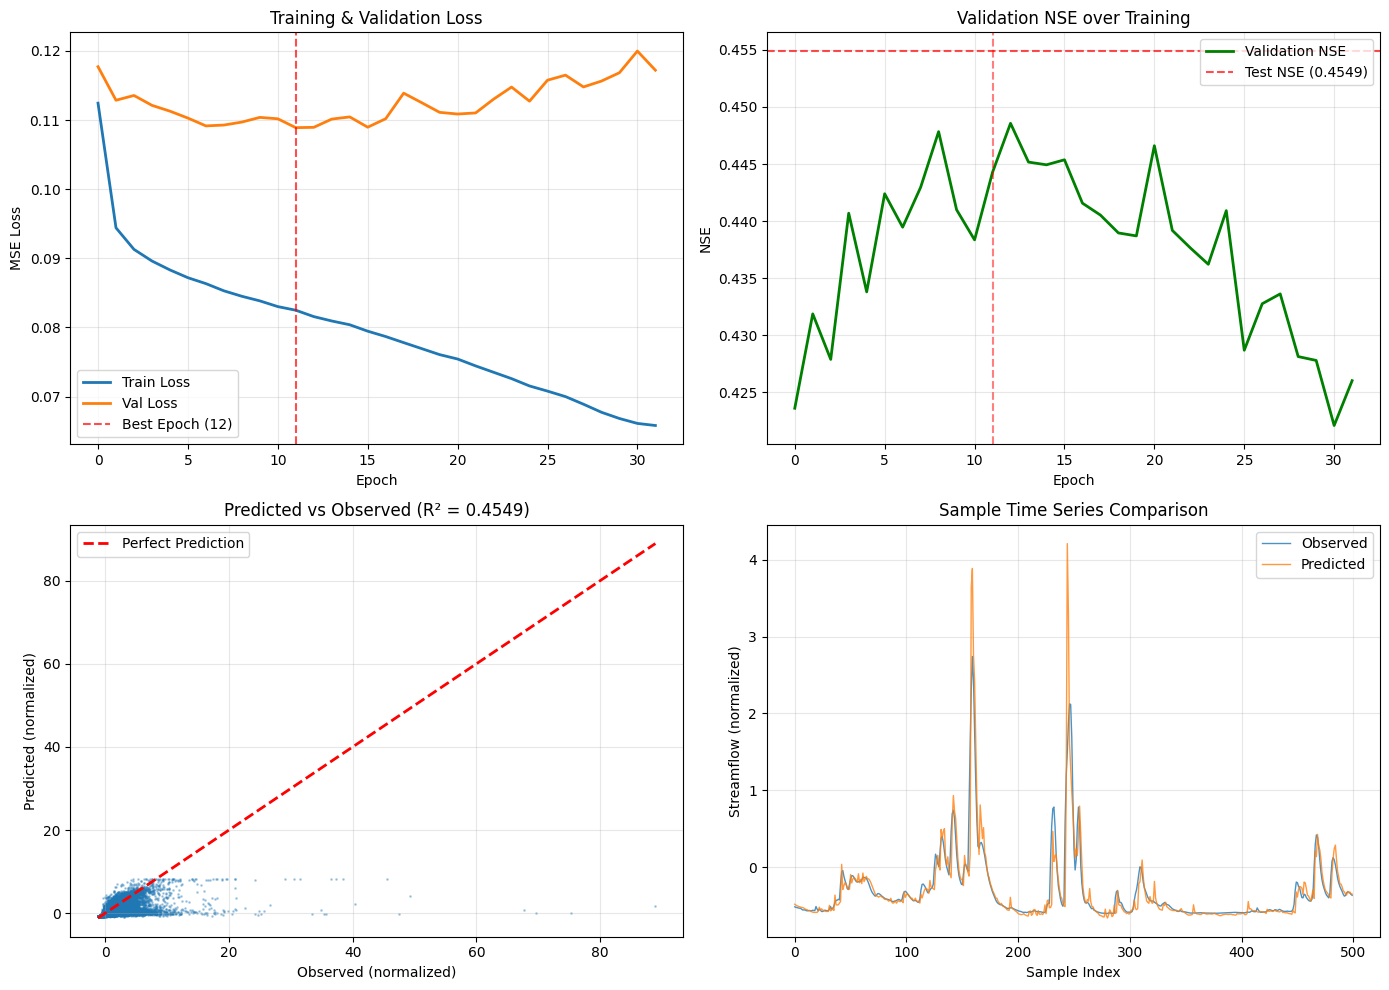


 Task 1 complete! Results saved to: results\task1\run_20251203_211020


In [18]:
# =============================================================================
# SECTION 7C: TASK 1 EVALUATION & RESULTS EXPORT
# =============================================================================

print("Evaluating Task 1 on Test Set...")

# Evaluate
preds_t1, targets_t1, metrics_t1 = evaluate_model(
    model_t1, test_loader_t1, DEVICE, task='task1'
)

print("\n" + "="*60)
print("TASK 1 TEST RESULTS")
print("="*60)
for metric, value in metrics_t1.items():
    print(f"   {metric}: {value}")
print("="*60)

# Prepare comprehensive results
task1_full_config = {
    **TASK1_CONFIG,
    'input_dim': input_dim_t1,
    'n_parameters': n_params,
    'num_basins': len(basin_ids),
    'use_static': USE_STATIC,
    'train_samples': len(X_train_t1),
    'val_samples': len(X_val_t1),
    'test_samples': len(X_test_t1),
}

task1_metrics = {
    'train': {'final_loss': history_t1['train_loss'][-1], 'final_nse': history_t1['val_nse'][-1]},
    'val': {'best_loss': min(history_t1['val_loss']), 'best_nse': max(history_t1['val_nse'])},
    'test': metrics_t1
}

task1_predictions = {
    'y_pred': preds_t1,
    'y_true': targets_t1,
    'basin_scalers': {k: v for k, v in preprocessor.basin_scalers.items()}
}

# Create optimizer for saving
optimizer_t1 = optim.Adam(model_t1.parameters(), lr=TASK1_CONFIG['lr'])

# Save comprehensive results
task1_run_dir = save_comprehensive_results(
    task_name='task1',
    model=model_t1,
    optimizer=optimizer_t1,
    config=task1_full_config,
    metrics=task1_metrics,
    history=history_t1,
    predictions=task1_predictions,
    epoch=history_t1['best_epoch']
)

# =============================================================================
# VISUALIZATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training curves
ax1 = axes[0, 0]
ax1.plot(history_t1['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history_t1['val_loss'], label='Val Loss', linewidth=2)
ax1.axvline(history_t1['best_epoch']-1, color='r', linestyle='--', alpha=0.7, label=f"Best Epoch ({history_t1['best_epoch']})")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. NSE curve
ax2 = axes[0, 1]
ax2.plot(history_t1['val_nse'], label='Validation NSE', linewidth=2, color='green')
ax2.axhline(metrics_t1['NSE'], color='red', linestyle='--', alpha=0.7, label=f"Test NSE ({metrics_t1['NSE']:.4f})")
ax2.axvline(history_t1['best_epoch']-1, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('NSE')
ax2.set_title('Validation NSE over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Scatter plot
ax3 = axes[1, 0]
ax3.scatter(targets_t1, preds_t1, alpha=0.3, s=1)
ax3.plot([targets_t1.min(), targets_t1.max()], [targets_t1.min(), targets_t1.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Observed (normalized)')
ax3.set_ylabel('Predicted (normalized)')
ax3.set_title(f'Predicted vs Observed (R² = {metrics_t1["R2"]:.4f})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Sample time series
ax4 = axes[1, 1]
sample_size = min(500, len(preds_t1))
ax4.plot(range(sample_size), targets_t1[:sample_size], label='Observed', alpha=0.8, linewidth=1)
ax4.plot(range(sample_size), preds_t1[:sample_size], label='Predicted', alpha=0.8, linewidth=1)
ax4.set_xlabel('Sample Index')
ax4.set_ylabel('Streamflow (normalized)')
ax4.set_title('Sample Time Series Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(task1_run_dir / 'training_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Task 1 complete! Results saved to: {task1_run_dir}")